In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from config_loader import load_config
import os
import json

In [2]:
# Load configuration
config, config_dir = load_config()
# Get the data path from the configuration
env = config['Settings']['environment']
data_path = config[env]['data_path']
demo_inferred_data_file = config['Data']['inferred_data_file']
column_names_file = config['Data']['training_dataset_columns_file']

In [3]:
# Read appliance names from the text file
with open(os.path.join(data_path, column_names_file), 'r') as file:
    column_names_json = json.load(file)

# Read the Parquet file
df = pd.read_parquet(os.path.join(data_path, demo_inferred_data_file))

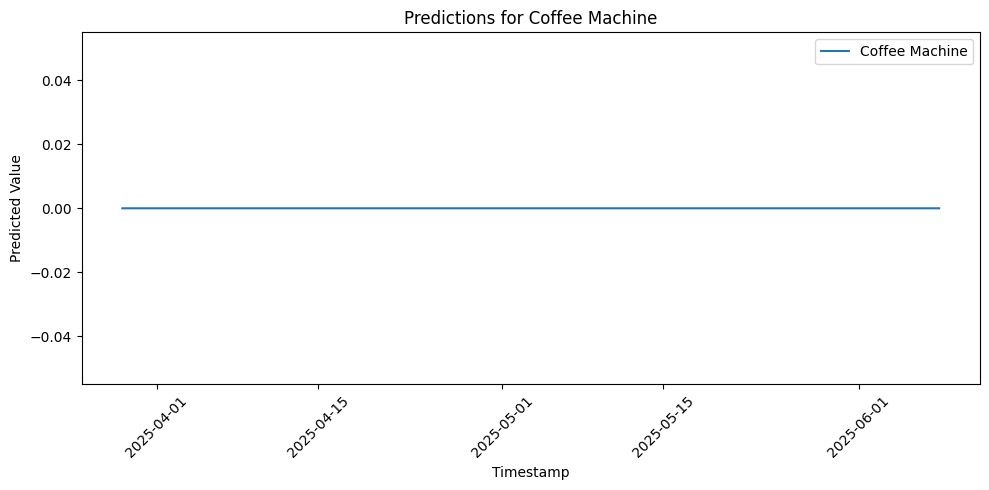

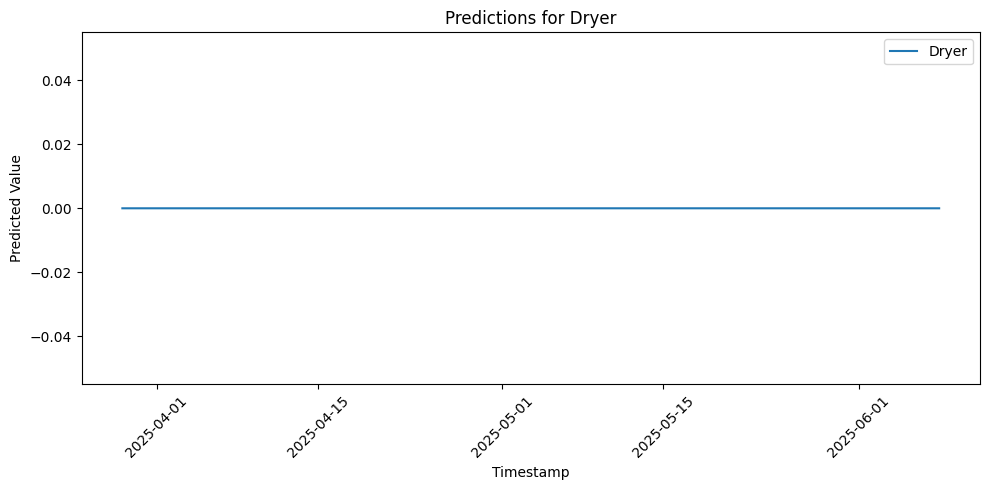

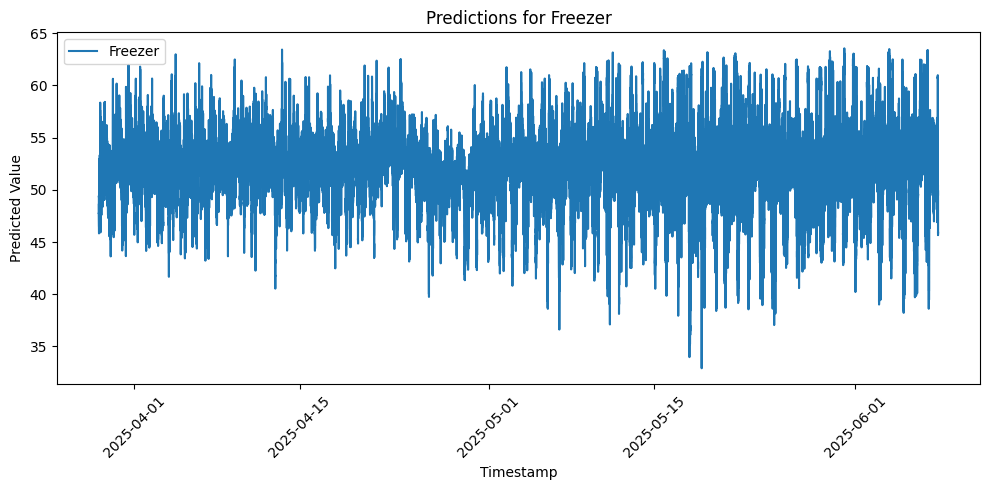

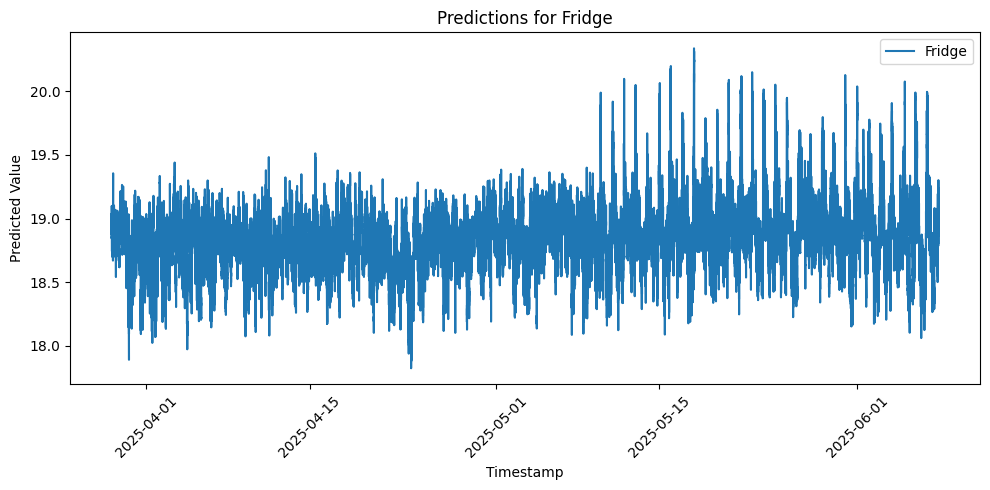

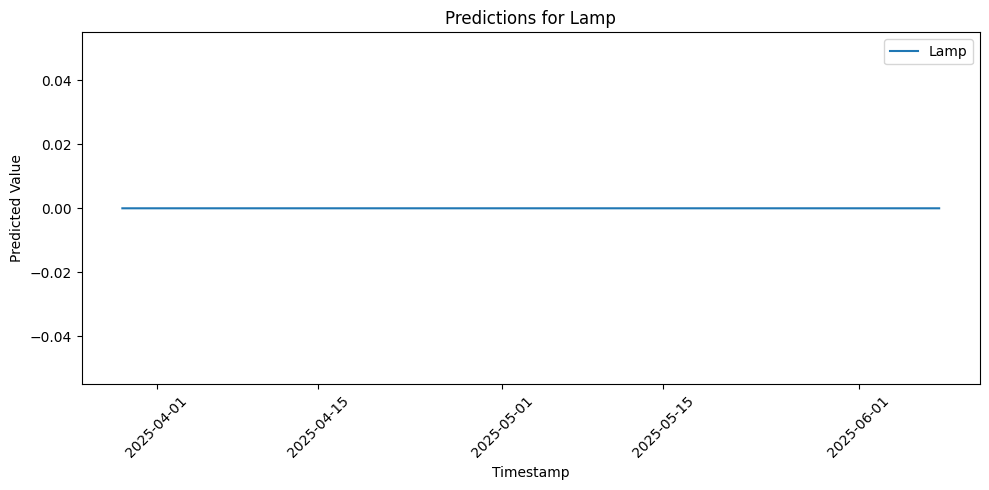

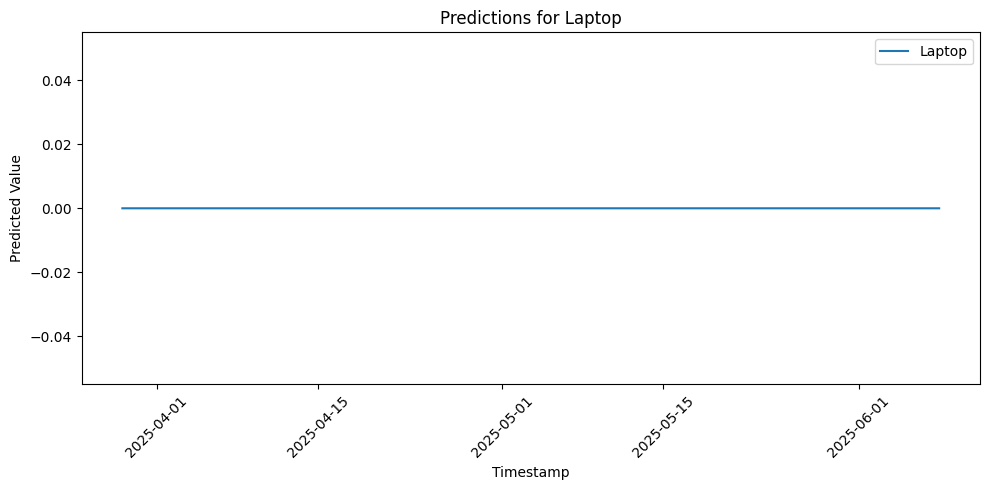

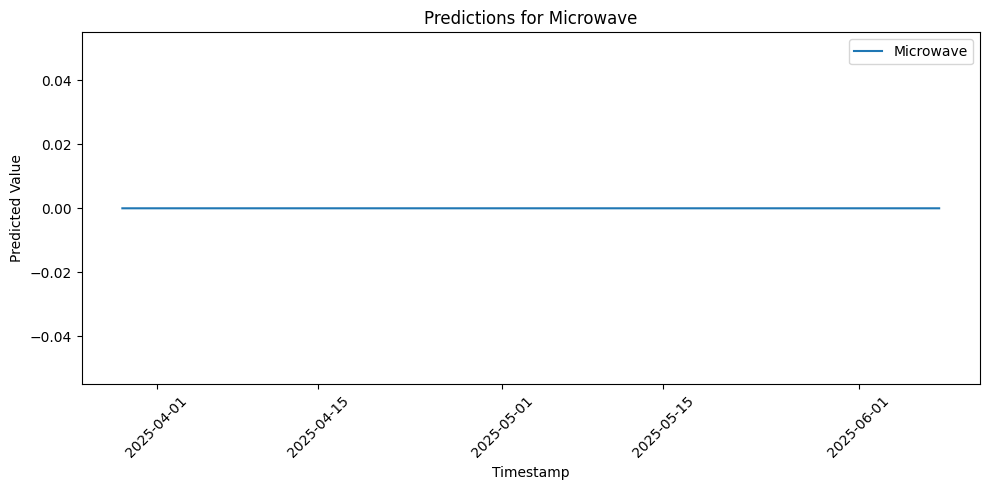

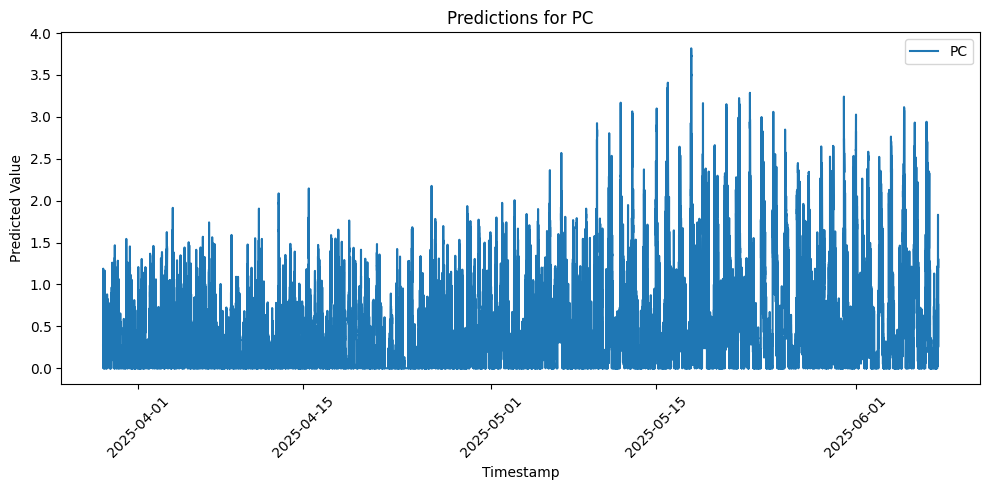

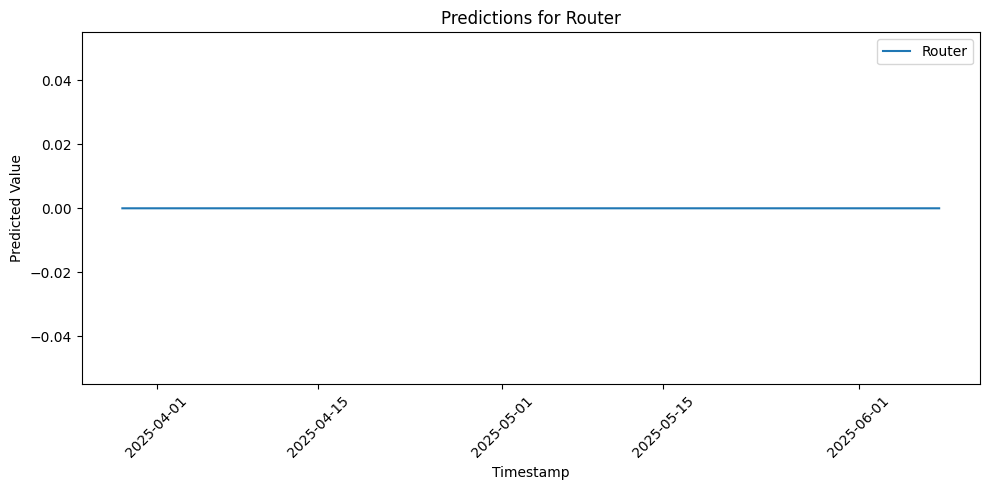

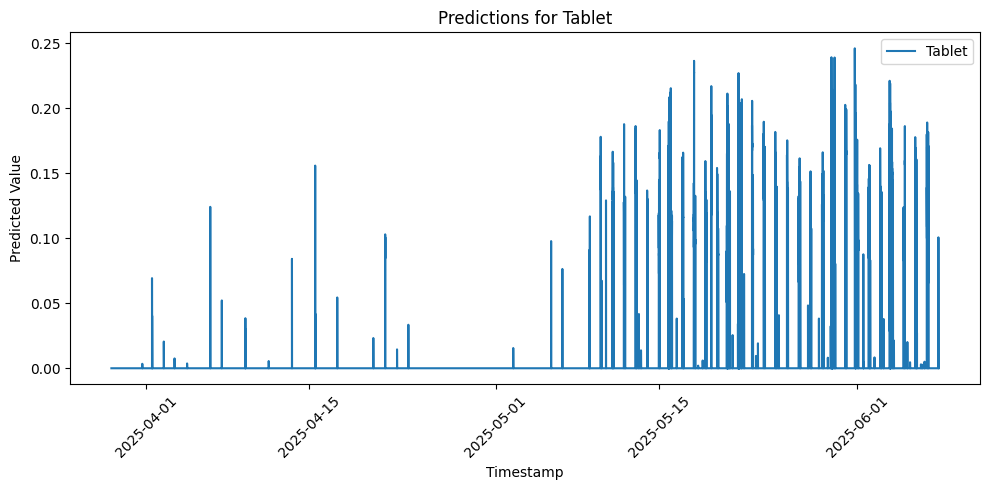

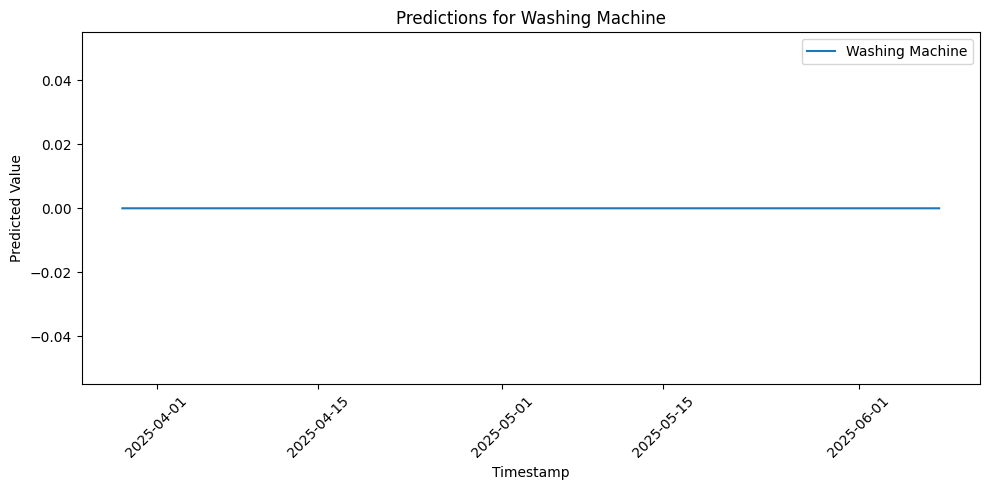

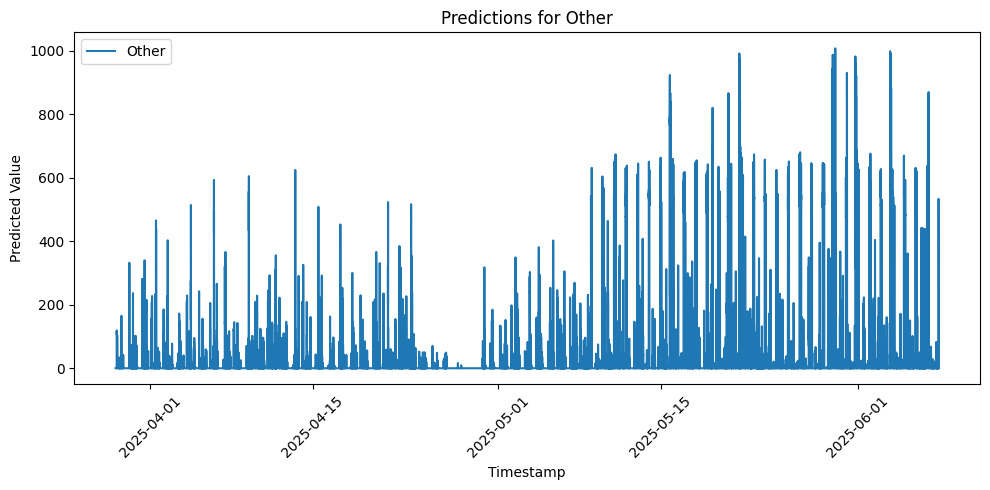

In [4]:
appliances = column_names_json['appliances']

# Loop over each appliance
for appliance in appliances:
    df_appliance = df[df['appliance'] == appliance]
    plt.figure(figsize=(10, 5))
    plt.plot(df_appliance['timestamp'], df_appliance['value'], label=appliance)
    plt.title(f'Predictions for {appliance}')
    plt.xlabel('Timestamp')
    plt.ylabel('Predicted Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
